<a href="https://colab.research.google.com/github/DataMastersUN/FA_T4/blob/main/Proyecto4G4FdeA2023_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Predicción del número de vehículos registrados en el sistema de tránsito nacional***

## ***Cargue y visualización de datos***

In [ ]:
#Librerias a utilizar
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# Statistics & Mathematics
import scipy.stats as stats
import statsmodels.api as sm

# Preprocessing data
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer, FunctionTransformer

# Model Selection for Cross Validation
from sklearn.model_selection import StratifiedKFold, KFold, train_test_split,TimeSeriesSplit

# Machine Learning metrics
from sklearn import metrics
from sklearn.neighbors import KNeighborsClassifier

# ML classifiers
from sklearn.ensemble import (
    HistGradientBoostingClassifier, AdaBoostClassifier,
    RandomForestClassifier, GradientBoostingClassifier,
    StackingClassifier, VotingClassifier
    )
from sklearn.linear_model import LogisticRegression
# Randomizer
import random
# Encoder of categorical variables
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import PoissonRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import r2_score
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [ ]:
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Cargamos la base de datos, le indicamos la ruta en donde se encuentra
data = pd.read_excel('/content/drive/Shareddrives/FdeAnaliticaG4/Proyecto4/data.xlsx')
data

,Fecha,Unidades
0,2012-01-01,0
1,2012-01-02,188
2,2012-01-03,482
3,2012-01-04,927
4,2012-01-05,1159
...,...,...
2187,2017-12-27,2102
2188,2017-12-28,3449
2189,2017-12-29,1084
2190,2017-12-30,18


In [ ]:
# Asegúrate de que la columna 'Fecha' esté en formato datetime
data['Fecha'] = pd.to_datetime(data['Fecha'])

# Establece 'Fecha' como el índice del DataFrame
data.set_index('Fecha', inplace=True)

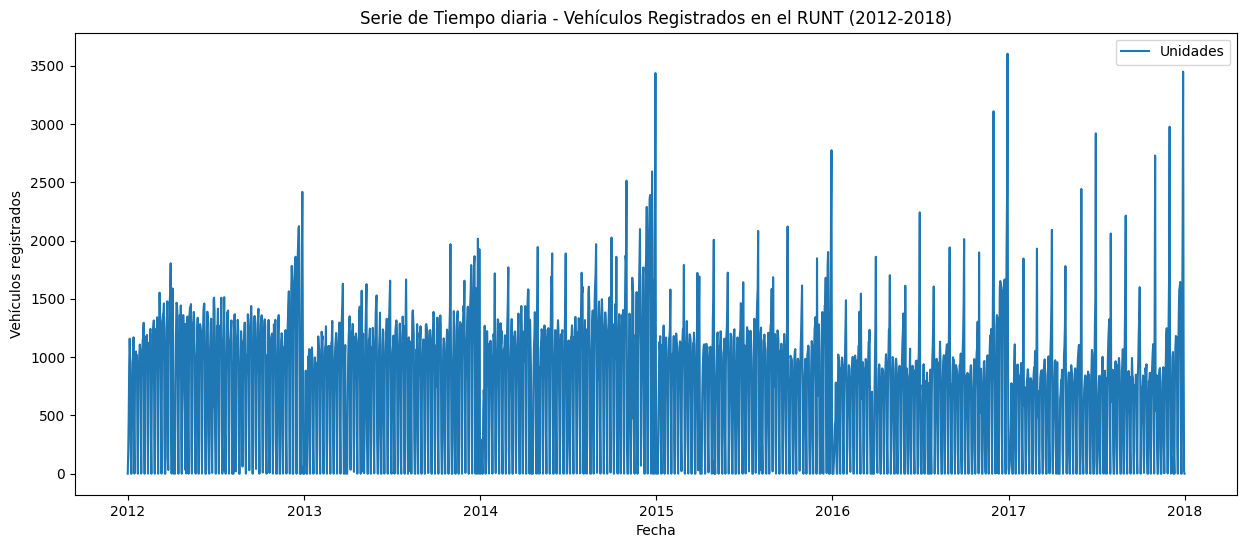

In [ ]:
# Grafica la serie de tiempo
plt.figure(figsize=(15, 6))
plt.plot(data['Unidades'], label='Unidades')
plt.title('Serie de Tiempo diaria - Vehículos Registrados en el RUNT (2012-2018)')
plt.xlabel('Fecha')
plt.ylabel('Vehículos registrados')
plt.legend()
plt.show()

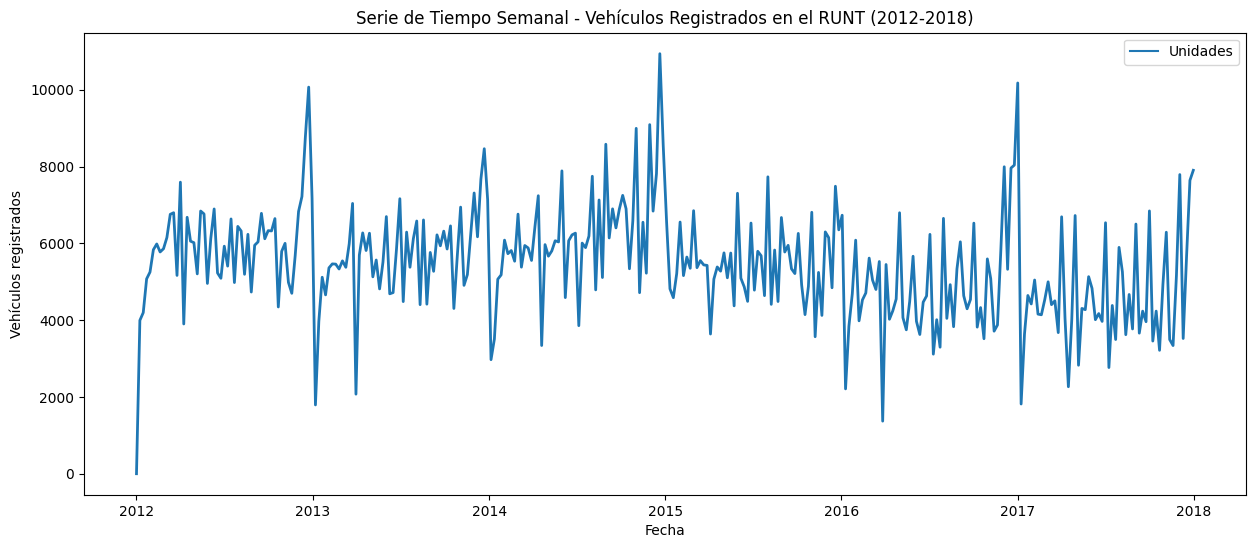

In [ ]:
plt.figure(figsize=(15, 6))
sns.lineplot(data=data.resample('W').sum(), linewidth=2)
plt.title('Serie de Tiempo Semanal - Vehículos Registrados en el RUNT (2012-2018)')
plt.xlabel('Fecha')
plt.ylabel('Vehículos registrados')
plt.legend()
plt.show()

## ***Análisis descriptivo***

In [ ]:
pd.DataFrame(data['Unidades'].describe())

,Unidades
count,2192.000000
mean,782.165602
std,551.164725
min,0.000000
25%,293.000000
50%,865.500000
75%,1173.000000
max,3603.000000


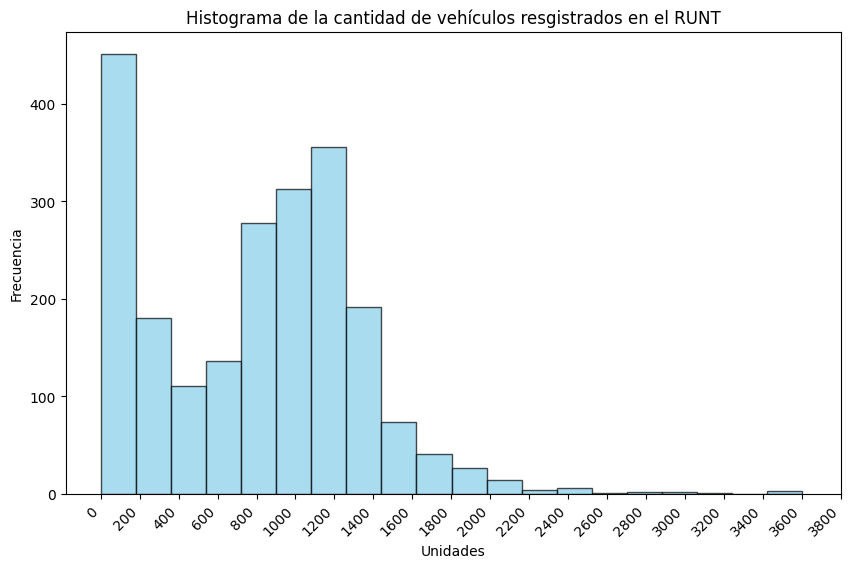

In [ ]:
plt.figure(figsize=(10, 6))
plt.hist(data['Unidades'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)
valores_x = range(0, int(data['Unidades'].max()) + 200, 200)
plt.xticks(valores_x, rotation=45, ha='right')
plt.xlabel('Unidades')
plt.ylabel('Frecuencia')
plt.title('Histograma de la cantidad de vehículos resgistrados en el RUNT')
plt.show()

In [ ]:
(data['Unidades']==0).sum()

272

In [ ]:
serie_mensual = data.resample('M').sum()
serie_mensual

,Unidades
Fecha,
2012-01-31,20390
2012-02-29,24840
2012-03-31,29217
2012-04-30,23945
2012-05-31,27066
...,...
2017-08-31,21029
2017-09-30,19436
2017-10-31,19815


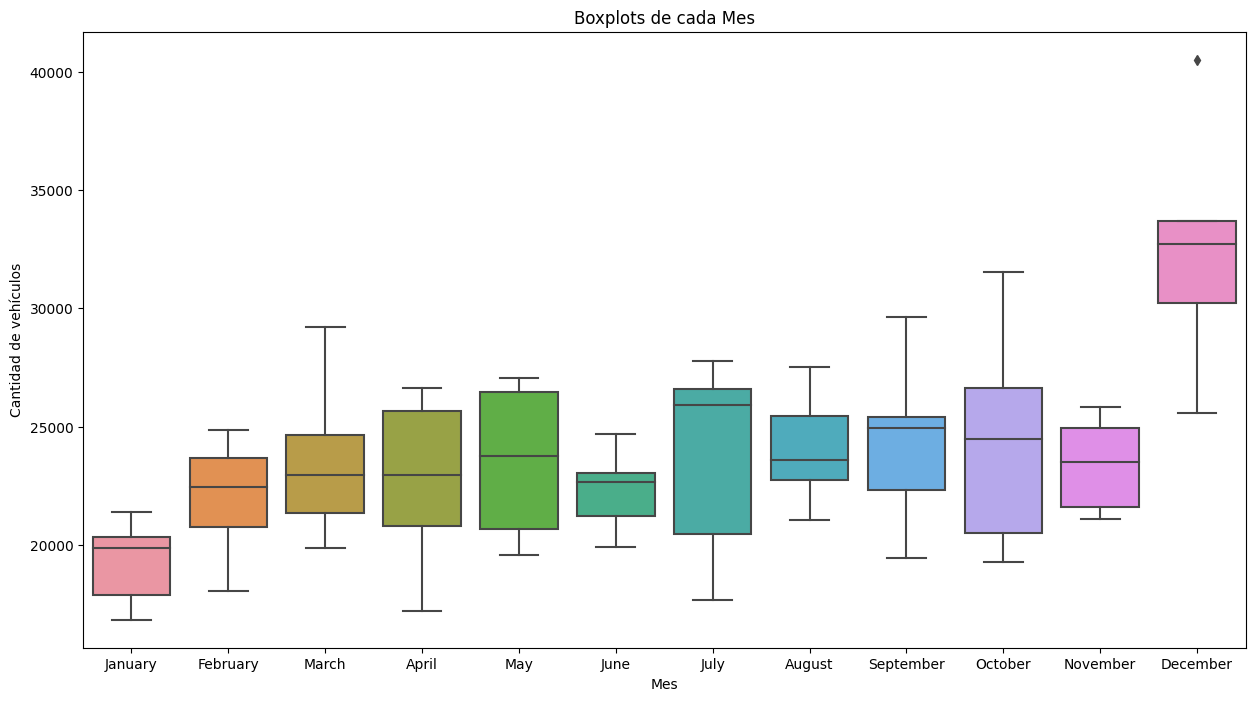

In [ ]:
serie_mensual.index = pd.to_datetime(serie_mensual.index)
serie_mensual['Mes'] = serie_mensual.index.strftime('%B')
plt.figure(figsize=(15, 8))
sns.boxplot(x='Mes', y='Unidades', data=serie_mensual)
plt.title('Boxplots de cada Mes')
plt.xlabel('Mes')
plt.ylabel('Cantidad de vehículos')
plt.show()

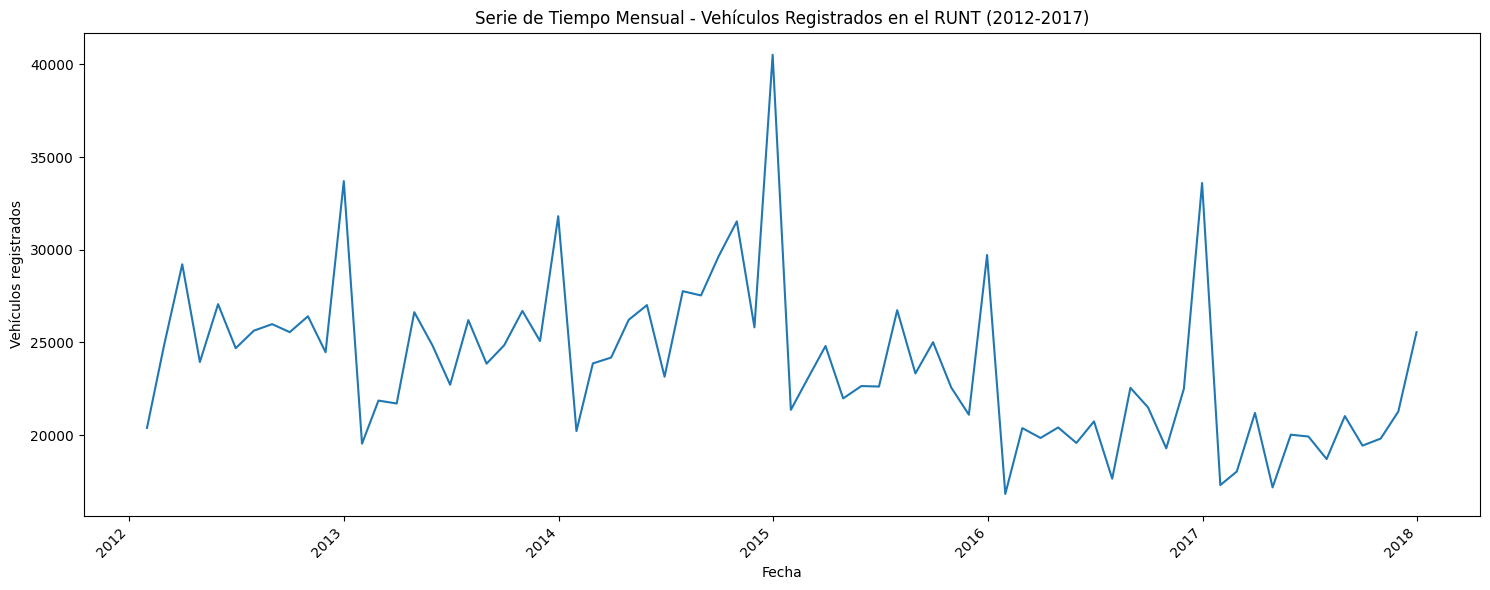

In [ ]:
plt.figure(figsize=(15, 6))
plt.plot(serie_mensual.index, serie_mensual['Unidades'], linestyle='-')

# Añadir etiquetas y título
plt.xlabel('Fecha')
plt.ylabel('Vehículos registrados')
plt.title('Serie de Tiempo Mensual - Vehículos Registrados en el RUNT (2012-2017)')

plt.xticks(rotation=45, ha='right')

# Mostrar la gráfica
plt.tight_layout()
plt.show()

# ***Modelos de Regresión***

## ***Elección de variables***

In [ ]:
data

,Fecha,Unidades
0,2012-01-01,0
1,2012-01-02,188
2,2012-01-03,482
3,2012-01-04,927
4,2012-01-05,1159
...,...,...
2187,2017-12-27,2102
2188,2017-12-28,3449
2189,2017-12-29,1084
2190,2017-12-30,18


In [ ]:
data['Fecha'] = pd.to_datetime(data['Fecha'])
data['diaMes'] = data['Fecha'].dt.day
data['diaSemana'] = data['Fecha'].dt.day_name()
data['anio'] = data['Fecha'].dt.year
data['mes'] = data['Fecha'].dt.month
data

,Fecha,Unidades,diaMes,diaSemana,anio,mes
0,2012-01-01,0,1,Sunday,2012,1
1,2012-01-02,188,2,Monday,2012,1
2,2012-01-03,482,3,Tuesday,2012,1
3,2012-01-04,927,4,Wednesday,2012,1
4,2012-01-05,1159,5,Thursday,2012,1
...,...,...,...,...,...,...
2187,2017-12-27,2102,27,Wednesday,2017,12
2188,2017-12-28,3449,28,Thursday,2017,12
2189,2017-12-29,1084,29,Friday,2017,12
2190,2017-12-30,18,30,Saturday,2017,12


In [ ]:
import holidays
from datetime import date
festivos = []
años = list(range(2010, 2020))
for año in años:
    festivos_año = holidays.CO(years=año)
    for fecha, nombre in sorted(festivos_año.items()):
        festivos.append((fecha))

In [ ]:
data['esFestivo'] = data['Fecha'].isin(festivos).astype(int)
data

,Fecha,Unidades,diaMes,diaSemana,anio,mes,esFestivo
0,2012-01-01,0,1,Sunday,2012,1,1
1,2012-01-02,188,2,Monday,2012,1,0
2,2012-01-03,482,3,Tuesday,2012,1,0
3,2012-01-04,927,4,Wednesday,2012,1,0
4,2012-01-05,1159,5,Thursday,2012,1,0
...,...,...,...,...,...,...,...
2187,2017-12-27,2102,27,Wednesday,2017,12,0
2188,2017-12-28,3449,28,Thursday,2017,12,0
2189,2017-12-29,1084,29,Friday,2017,12,0
2190,2017-12-30,18,30,Saturday,2017,12,0


In [ ]:
data[data['esFestivo']==1]

,Fecha,Unidades,diaMes,diaSemana,anio,mes,esFestivo
0,2012-01-01,0,1,Sunday,2012,1,1
8,2012-01-09,0,9,Monday,2012,1,1
78,2012-03-19,0,19,Monday,2012,3,1
95,2012-04-05,1,5,Thursday,2012,4,1
96,2012-04-06,0,6,Friday,2012,4,1
...,...,...,...,...,...,...,...
2115,2017-10-16,0,16,Monday,2017,10,1
2136,2017-11-06,0,6,Monday,2017,11,1
2143,2017-11-13,0,13,Monday,2017,11,1
2168,2017-12-08,1,8,Friday,2017,12,1


In [ ]:
data['esQuincena'] = (data['Fecha'].dt.day.isin([15, 30])).astype(int)
data

,Fecha,Unidades,diaMes,diaSemana,anio,mes,esFestivo,esQuincena
0,2012-01-01,0,1,Sunday,2012,1,1,0
1,2012-01-02,188,2,Monday,2012,1,0,0
2,2012-01-03,482,3,Tuesday,2012,1,0,0
3,2012-01-04,927,4,Wednesday,2012,1,0,0
4,2012-01-05,1159,5,Thursday,2012,1,0,0
...,...,...,...,...,...,...,...,...
2187,2017-12-27,2102,27,Wednesday,2017,12,0,0
2188,2017-12-28,3449,28,Thursday,2017,12,0,0
2189,2017-12-29,1084,29,Friday,2017,12,0,0
2190,2017-12-30,18,30,Saturday,2017,12,0,1


In [ ]:
data['diaAnio'] = data['Fecha'].dt.dayofyear
data

,Fecha,Unidades,diaMes,diaSemana,anio,mes,esFestivo,esQuincena,diaAnio
0,2012-01-01,0,1,Sunday,2012,1,1,0,1
1,2012-01-02,188,2,Monday,2012,1,0,0,2
2,2012-01-03,482,3,Tuesday,2012,1,0,0,3
3,2012-01-04,927,4,Wednesday,2012,1,0,0,4
4,2012-01-05,1159,5,Thursday,2012,1,0,0,5
...,...,...,...,...,...,...,...,...,...
2187,2017-12-27,2102,27,Wednesday,2017,12,0,0,361
2188,2017-12-28,3449,28,Thursday,2017,12,0,0,362
2189,2017-12-29,1084,29,Friday,2017,12,0,0,363
2190,2017-12-30,18,30,Saturday,2017,12,0,1,364


In [ ]:
data['esFinDeSemana'] = data.apply(lambda fila: 1 if (fila['diaSemana']=='Saturday' or fila['diaSemana']=='Sunday') else 0,axis=1)
data

,Fecha,Unidades,diaMes,diaSemana,anio,mes,esFestivo,esQuincena,diaAnio,esFinDeSemana
0,2012-01-01,0,1,Sunday,2012,1,1,0,1,1
1,2012-01-02,188,2,Monday,2012,1,0,0,2,0
2,2012-01-03,482,3,Tuesday,2012,1,0,0,3,0
3,2012-01-04,927,4,Wednesday,2012,1,0,0,4,0
4,2012-01-05,1159,5,Thursday,2012,1,0,0,5,0
...,...,...,...,...,...,...,...,...,...,...
2187,2017-12-27,2102,27,Wednesday,2017,12,0,0,361,0
2188,2017-12-28,3449,28,Thursday,2017,12,0,0,362,0
2189,2017-12-29,1084,29,Friday,2017,12,0,0,363,0
2190,2017-12-30,18,30,Saturday,2017,12,0,1,364,1


In [ ]:
data['ultimoDiaHabilMes'] = (data['Fecha'] + pd.offsets.BMonthEnd(0)).dt.day == data['Fecha'].dt.day
data['ultimoDiaHabilMes'] = data['ultimoDiaHabilMes'].astype(int)
data

,Fecha,Unidades,diaMes,diaSemana,anio,mes,esFestivo,esQuincena,diaAnio,esFinDeSemana,ultimoDiaHabilMes
0,2012-01-01,0,1,Sunday,2012,1,1,0,1,1,0
1,2012-01-02,188,2,Monday,2012,1,0,0,2,0,0
2,2012-01-03,482,3,Tuesday,2012,1,0,0,3,0,0
3,2012-01-04,927,4,Wednesday,2012,1,0,0,4,0,0
4,2012-01-05,1159,5,Thursday,2012,1,0,0,5,0,0
...,...,...,...,...,...,...,...,...,...,...,...
2187,2017-12-27,2102,27,Wednesday,2017,12,0,0,361,0,0
2188,2017-12-28,3449,28,Thursday,2017,12,0,0,362,0,0
2189,2017-12-29,1084,29,Friday,2017,12,0,0,363,0,1
2190,2017-12-30,18,30,Saturday,2017,12,0,1,364,1,0


In [ ]:
data_p = data.drop(columns='Fecha',axis=1)
data_d= data_p.copy()
data_p

,Unidades,diaMes,diaSemana,anio,mes,esFestivo,esQuincena,diaAnio,esFinDeSemana,ultimoDiaHabilMes
0,0,1,Sunday,2012,1,1,0,1,1,0
1,188,2,Monday,2012,1,0,0,2,0,0
2,482,3,Tuesday,2012,1,0,0,3,0,0
3,927,4,Wednesday,2012,1,0,0,4,0,0
4,1159,5,Thursday,2012,1,0,0,5,0,0
...,...,...,...,...,...,...,...,...,...,...
2187,2102,27,Wednesday,2017,12,0,0,361,0,0
2188,3449,28,Thursday,2017,12,0,0,362,0,0
2189,1084,29,Friday,2017,12,0,0,363,0,1
2190,18,30,Saturday,2017,12,0,1,364,1,0


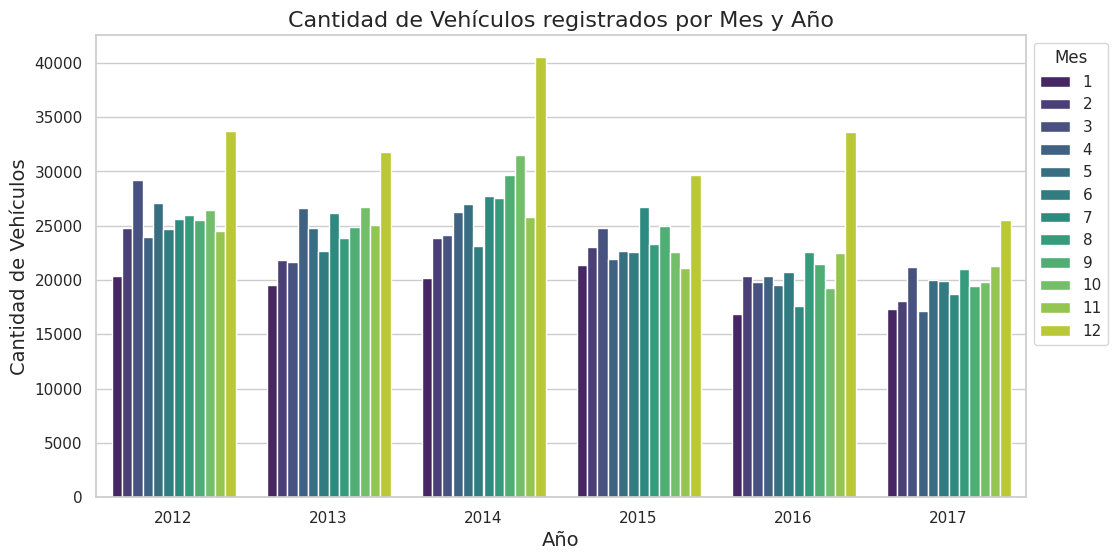

In [ ]:
# Convertir la columna 'diaSemana' a tipo categórico para ordenar los días de la semana correctamente
dias_semana_ordenados = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data_p['diaSemana'] = pd.Categorical(data_p['diaSemana'], categories=dias_semana_ordenados, ordered=True)

# Crear la gráfica utilizando seaborn
plt.figure(figsize=(12, 6))
sns.set(style='whitegrid', palette='viridis')
colors = sns.color_palette("viridis", 12)
# Agrupar por año y mes, sumar las unidades y graficar
sns.barplot(data=data_p, x='anio', y='Unidades', hue='mes', estimator='sum', errorbar=None,palette=colors)

# Configurar el estilo y las etiquetas
plt.title('Cantidad de Vehículos registrados por Mes y Año', fontsize=16)
plt.xlabel('Año', fontsize=14)
plt.ylabel('Cantidad de Vehículos', fontsize=14)
plt.legend(title='Mes', bbox_to_anchor=(1, 1))
plt.show()

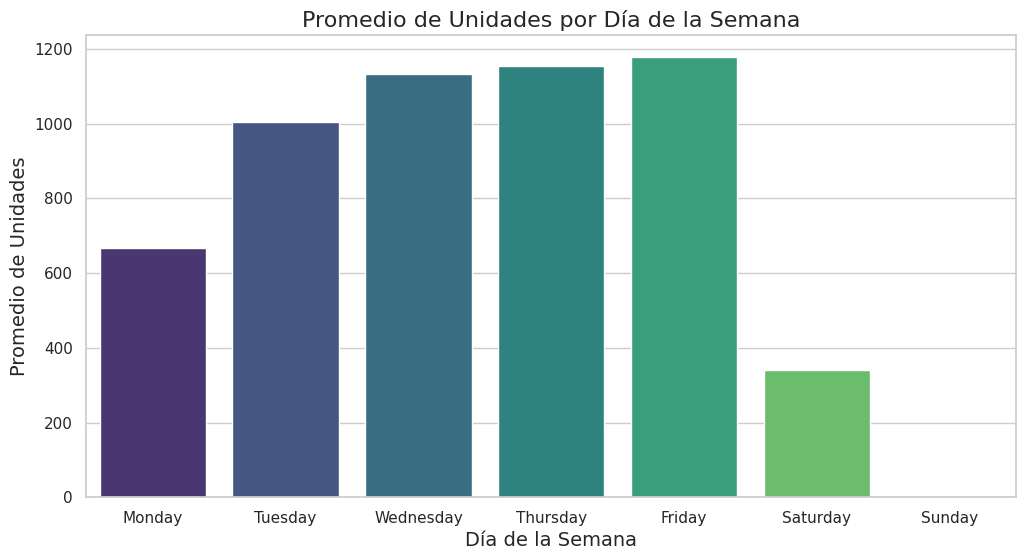

In [ ]:
dias_semana_ordenados = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
data_p['diaSemana'] = pd.Categorical(data_p['diaSemana'], categories=dias_semana_ordenados, ordered=True)

# Crear la gráfica utilizando seaborn
plt.figure(figsize=(12, 6))
sns.set(style='whitegrid', palette='viridis')
colors = sns.color_palette("viridis", 7)
# Agrupar por día de la semana, calcular el promedio de unidades y graficar
sns.barplot(data=data_p, x='diaSemana', y='Unidades', estimator='mean', errorbar=None,palette=colors)

# Configurar el estilo y las etiquetas
plt.title('Promedio de Unidades por Día de la Semana', fontsize=16)
plt.xlabel('Día de la Semana', fontsize=14)
plt.ylabel('Promedio de Unidades', fontsize=14)
plt.show()

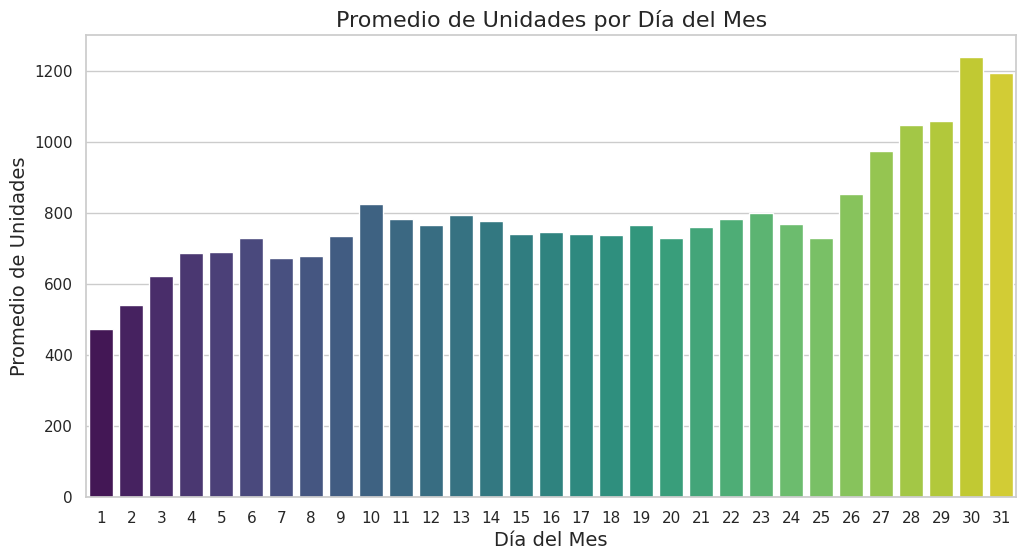

In [ ]:
plt.figure(figsize=(12, 6))
colors = sns.color_palette("viridis", 31)

# Agrupar por día del mes, calcular el promedio de unidades y graficar
sns.barplot(data=data_p, x='diaMes', y='Unidades', estimator='mean',  errorbar=None,palette=colors)

# Configurar el estilo y las etiquetas
plt.title('Promedio de Unidades por Día del Mes', fontsize=16)
plt.xlabel('Día del Mes', fontsize=14)
plt.ylabel('Promedio de Unidades', fontsize=14)
plt.show()

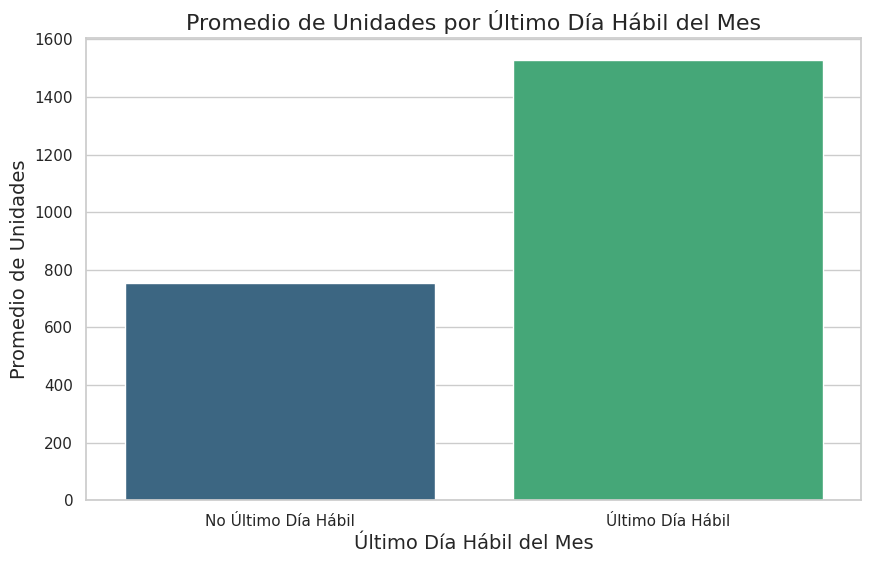

In [ ]:
plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", 2)

# Agrupar por si es último día hábil del mes o no, calcular el promedio de unidades y graficar
sns.barplot(data=data_p, x='ultimoDiaHabilMes', y='Unidades', estimator='mean', errorbar=None,palette=colors)

# Configurar el estilo y las etiquetas
plt.title('Promedio de Unidades por Último Día Hábil del Mes', fontsize=16)
plt.xlabel('Último Día Hábil del Mes', fontsize=14)
plt.ylabel('Promedio de Unidades', fontsize=14)
plt.xticks([0, 1], ['No Último Día Hábil', 'Último Día Hábil'])  # Etiquetas para el eje x

plt.show()

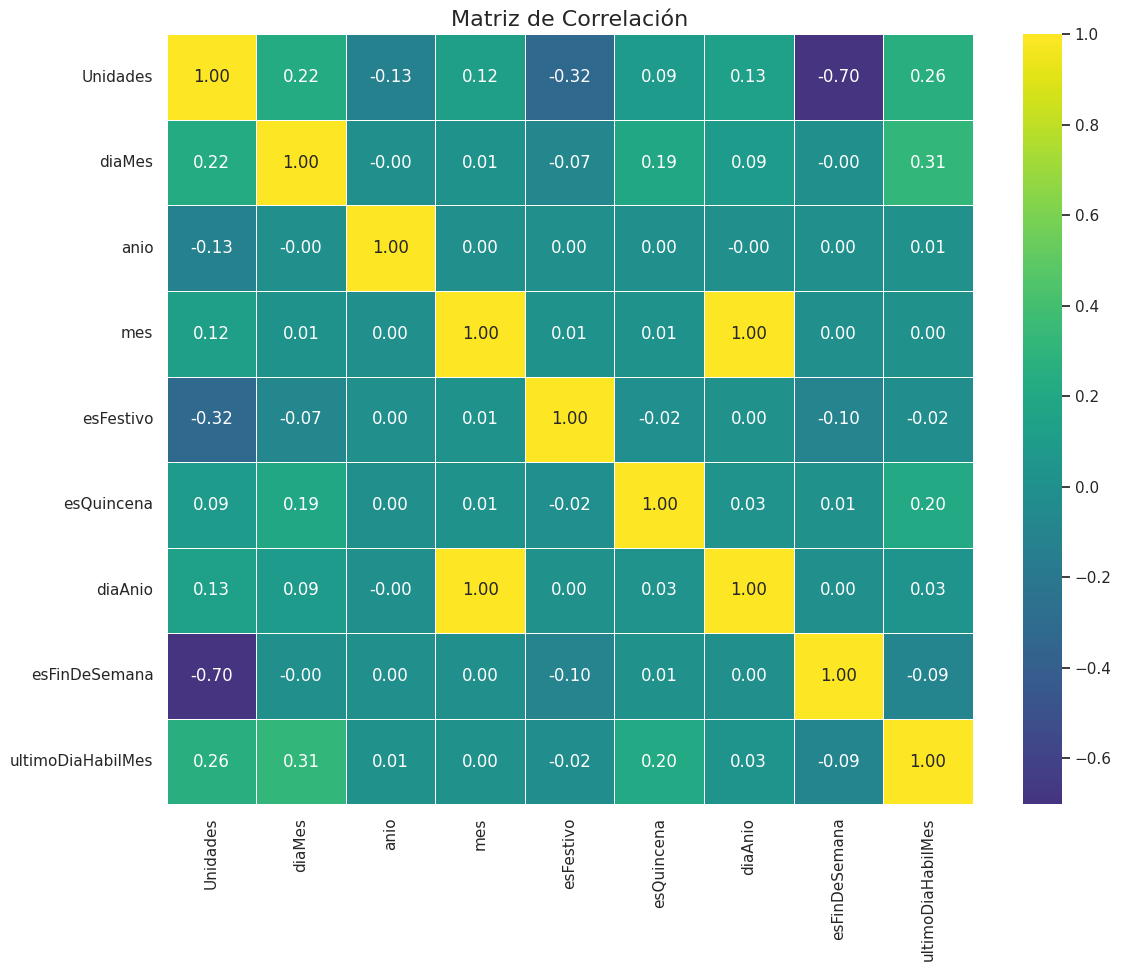

In [ ]:
correlation_matrix = data_p.corr(numeric_only=True)
plt.figure(figsize=(13, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0, fmt=".2f", linewidths=0.5, cbar=True)
plt.title('Matriz de Correlación', fontsize=16)
plt.show()

In [ ]:
data_p = pd.get_dummies(data_p, columns=['diaSemana'], prefix='diaSemana', drop_first=True)
data_p

,Unidades,diaMes,anio,mes,esFestivo,esQuincena,diaAnio,esFinDeSemana,ultimoDiaHabilMes,diaSemana_Monday,diaSemana_Saturday,diaSemana_Sunday,diaSemana_Thursday,diaSemana_Tuesday,diaSemana_Wednesday
0,0,1,2012,1,1,0,1,1,0,0,0,1,0,0,0
1,188,2,2012,1,0,0,2,0,0,1,0,0,0,0,0
2,482,3,2012,1,0,0,3,0,0,0,0,0,0,1,0
3,927,4,2012,1,0,0,4,0,0,0,0,0,0,0,1
4,1159,5,2012,1,0,0,5,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,2102,27,2017,12,0,0,361,0,0,0,0,0,0,0,1
2188,3449,28,2017,12,0,0,362,0,0,0,0,0,1,0,0
2189,1084,29,2017,12,0,0,363,0,1,0,0,0,0,0,0
2190,18,30,2017,12,0,1,364,1,0,0,1,0,0,0,0


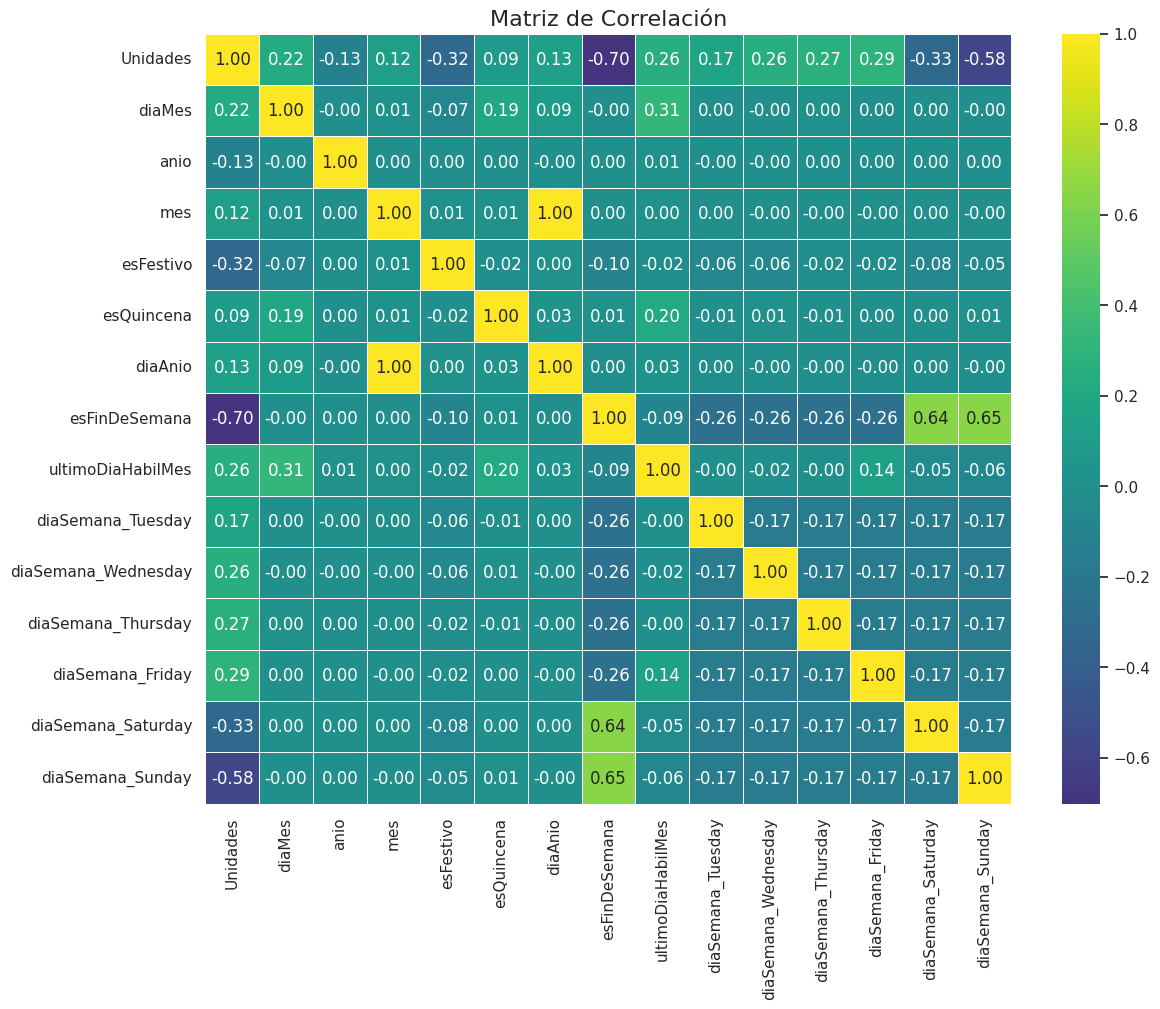

In [ ]:
correlation_matrix = data_p.corr(numeric_only=True)
plt.figure(figsize=(13, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='viridis', center=0, fmt=".2f", linewidths=0.5, cbar=True)
plt.title('Matriz de Correlación', fontsize=16)
plt.show()

Como se puede apreciar las variables diaAnio y mes están correlacionadas, por lo que se va eliminar diaAnio ya que tiene menos efecto sobre la variable de interés.

## ***Ajuste de modelos***

In [ ]:
data_train = data_p[data_p['anio'] < 2017]
data_val = data_p[data_p['anio'] == 2017]

### ***1: David***

#### ***Creamos las estructuras de datos***

In [ ]:
data_d1 = data_d.copy()
data_d2 = data_d.copy()
data_d3 = data_d.copy()
data_d4 = data_d.copy()
data_d5 = data_d.copy()
data_d

,Unidades,diaMes,diaSemana,anio,mes,esFestivo,esQuincena,diaAnio,esFinDeSemana,ultimoDiaHabilMes
0,0,1,Sunday,2012,1,1,0,1,1,0
1,188,2,Monday,2012,1,0,0,2,0,0
2,482,3,Tuesday,2012,1,0,0,3,0,0
3,927,4,Wednesday,2012,1,0,0,4,0,0
4,1159,5,Thursday,2012,1,0,0,5,0,0
...,...,...,...,...,...,...,...,...,...,...
2187,2102,27,Wednesday,2017,12,0,0,361,0,0
2188,3449,28,Thursday,2017,12,0,0,362,0,0
2189,1084,29,Friday,2017,12,0,0,363,0,1
2190,18,30,Saturday,2017,12,0,1,364,1,0


***Estructura 1:  Volver dia de la semana y mes a variables dummys***


In [ ]:
data_d1 = pd.get_dummies(data_d1, columns=['diaSemana','mes'], prefix=['diaSemana','mes'], drop_first=True)
data_d1

***Estructura 2: Volver dia de la semana a números (1,2,3,4,5,6,7)***

In [ ]:
data_d2

In [ ]:
dias_semana_dict = {
    'Monday': 1,
    'Tuesday': 2,
    'Wednesday': 3,
    'Thursday': 4,
    'Friday': 5,
    'Saturday': 6,
    'Sunday': 7
}

data_d2['diaSemana'] = data_d2['diaSemana'].map(dias_semana_dict)
data_d2

,Unidades,diaMes,diaSemana,anio,mes,esFestivo,esQuincena,diaAnio,esFinDeSemana,ultimoDiaHabilMes
0,0,1,7,2012,1,1,0,1,1,0
1,188,2,1,2012,1,0,0,2,0,0
2,482,3,2,2012,1,0,0,3,0,0
3,927,4,3,2012,1,0,0,4,0,0
4,1159,5,4,2012,1,0,0,5,0,0
...,...,...,...,...,...,...,...,...,...,...
2187,2102,27,3,2017,12,0,0,361,0,0
2188,3449,28,4,2017,12,0,0,362,0,0
2189,1084,29,5,2017,12,0,0,363,0,1
2190,18,30,6,2017,12,0,1,364,1,0


***Estructura 3: Volver dia de la semana a números (1,2,3,4,5,6,7) y mes a variable dummy***

In [ ]:
data_d3['diaSemana'] = data_d3['diaSemana'].map(dias_semana_dict)
data_d3 = pd.get_dummies(data_d3, columns=['mes'], prefix=['mes'], drop_first=True)
data_d3

,Unidades,diaMes,diaSemana,anio,esFestivo,esQuincena,diaAnio,esFinDeSemana,ultimoDiaHabilMes,mes_2,mes_3,mes_4,mes_5,mes_6,mes_7,mes_8,mes_9,mes_10,mes_11,mes_12
0,0,1,7,2012,1,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,188,2,1,2012,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0
2,482,3,2,2012,0,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0
3,927,4,3,2012,0,0,4,0,0,0,0,0,0,0,0,0,0,0,0,0
4,1159,5,4,2012,0,0,5,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,2102,27,3,2017,0,0,361,0,0,0,0,0,0,0,0,0,0,0,0,1
2188,3449,28,4,2017,0,0,362,0,0,0,0,0,0,0,0,0,0,0,0,1
2189,1084,29,5,2017,0,0,363,0,1,0,0,0,0,0,0,0,0,0,0,1
2190,18,30,6,2017,0,1,364,1,0,0,0,0,0,0,0,0,0,0,0,1


***Estructura 4: Volver dia de la semana a números (1,2,3,4,5,6,7) y borrar el mes por multicolinealidad con diaAnio***

In [ ]:
data_d4['diaSemana'] = data_d4['diaSemana'].map(dias_semana_dict)
data_d4 = data_d4.drop(columns='mes',axis=1)
data_d4

,Unidades,diaMes,diaSemana,anio,esFestivo,esQuincena,diaAnio,esFinDeSemana,ultimoDiaHabilMes
0,0,1,7,2012,1,0,1,1,0
1,188,2,1,2012,0,0,2,0,0
2,482,3,2,2012,0,0,3,0,0
3,927,4,3,2012,0,0,4,0,0
4,1159,5,4,2012,0,0,5,0,0
...,...,...,...,...,...,...,...,...,...
2187,2102,27,3,2017,0,0,361,0,0
2188,3449,28,4,2017,0,0,362,0,0
2189,1084,29,5,2017,0,0,363,0,1
2190,18,30,6,2017,0,1,364,1,0


***Estructura 5: Volver dia de la semana a variable dummy y borrar el mes por multicolinealidad con diaAnio***

In [ ]:
data_d5 = pd.get_dummies(data_d5, columns=['diaSemana'], prefix=['diaSemana'], drop_first=True)
data_d5 = data_d5.drop(columns='mes',axis=1)
data_d5

,Unidades,diaMes,anio,esFestivo,esQuincena,diaAnio,esFinDeSemana,ultimoDiaHabilMes,diaSemana_Monday,diaSemana_Saturday,diaSemana_Sunday,diaSemana_Thursday,diaSemana_Tuesday,diaSemana_Wednesday
0,0,1,2012,1,0,1,1,0,0,0,1,0,0,0
1,188,2,2012,0,0,2,0,0,1,0,0,0,0,0
2,482,3,2012,0,0,3,0,0,0,0,0,0,1,0
3,927,4,2012,0,0,4,0,0,0,0,0,0,0,1
4,1159,5,2012,0,0,5,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2187,2102,27,2017,0,0,361,0,0,0,0,0,0,0,1
2188,3449,28,2017,0,0,362,0,0,0,0,0,1,0,0
2189,1084,29,2017,0,0,363,0,1,0,0,0,0,0,0
2190,18,30,2017,0,1,364,1,0,0,1,0,0,0,0


#### ***Probamos modelos***

In [ ]:
data_train = data_d5[data_d5['anio'] < 2017]
data_val = data_d5[data_d5['anio'] == 2017]

In [ ]:
data_train

,Unidades,diaMes,diaSemana,anio,mes,esFestivo,esQuincena,diaAnio,esFinDeSemana,ultimoDiaHabilMes
0,0,1,7,2012,1,1,0,1,1,0
1,188,2,1,2012,1,0,0,2,0,0
2,482,3,2,2012,1,0,0,3,0,0
3,927,4,3,2012,1,0,0,4,0,0
4,1159,5,4,2012,1,0,0,5,0,0
...,...,...,...,...,...,...,...,...,...,...
1822,1922,27,2,2016,12,0,0,362,0,0
1823,2409,28,3,2016,12,0,0,363,0,0
1824,3603,29,4,2016,12,0,0,364,0,0
1825,965,30,5,2016,12,0,1,365,0,1


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

# Dividir los datos en características (X) y la variable objetivo (y)
X_train = data_train.drop(['Unidades'], axis=1)
y_train = data_train['Unidades']
X_val = data_val.drop(['Unidades'], axis=1)
y_val = data_val['Unidades']

# Inicializar y ajustar el modelo de regresión lineal múltiple
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# Predecir con el conjunto de entrenamiento y validación
y_pred_train = linear_model.predict(X_train)
y_pred_val = linear_model.predict(X_val)

# Calcular R2 para entrenamiento y validación
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
r2_difference_percentage = ((r2_train-r2_val ) /r2_train) * 100
r2_difference_percentage2 = ((r2_val-r2_train ) /r2_val) * 100

# Imprimir los resultados
print(f'R2 de entrenamiento: {r2_train}')
print(f'R2 de validación: {r2_val}')
print(f'Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: {r2_difference_percentage:.2f}%')
print(f'Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: {r2_difference_percentage2:.2f}%')

R2 de entrenamiento: 0.8093743708241558
R2 de validación: 0.69122848495788
Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: 14.60%
Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: -17.09%


In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

# Separar las variables predictoras y la variable de respuesta
X_train = data_train.drop('Unidades', axis=1)
y_train = data_train['Unidades']
X_val = data_val.drop('Unidades', axis=1)
y_val = data_val['Unidades']

# Inicializar y ajustar el modelo SVM
svm_model = SVR(kernel='linear')  # Puedes ajustar el kernel según tus necesidades
svm_model.fit(X_train, y_train)

# Predecir en los conjuntos de entrenamiento y validación
y_pred_train = svm_model.predict(X_train)
y_pred_val = svm_model.predict(X_val)

# Calcular las métricas en los conjuntos de entrenamiento y validación
r2_train = r2_score(y_train, y_pred_train)
mse_train = mean_squared_error(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
mse_val = mean_squared_error(y_val, y_pred_val)

# Calcular el porcentaje de variación entre entrenamiento y validación
r2_difference_percentage = ((r2_train - r2_val) / r2_train) * 100
mse_difference_percentage = ((mse_val - mse_train) / mse_val) * 100

# Imprimir los resultados
print(f'R2 de entrenamiento: {r2_train}')
print(f'R2 de validación: {r2_val}')
print(f'Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: {r2_difference_percentage:.2f}%')

R2 de entrenamiento: 0.6102426934348448
R2 de validación: 0.5755772289109082
Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: 5.68%


In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler

# Dividir los datos en características (X) y la variable objetivo (y)
X_train = data_train.drop(['Unidades'], axis=1)
y_train = data_train['Unidades']
X_val = data_val.drop(['Unidades'], axis=1)
y_val = data_val['Unidades']

# Inicializar y ajustar el modelo de KNN con estandarización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
for vecino in range(1,15):
  knn_model = KNeighborsRegressor(n_neighbors=vecino)  # Puedes ajustar el número de vecinos según tu preferencia
  knn_model.fit(X_train_scaled, y_train)

  # Predecir con el conjunto de entrenamiento y validación
  y_pred_train = knn_model.predict(X_train_scaled)
  y_pred_val = knn_model.predict(X_val_scaled)

  # Calcular R2 para entrenamiento y validación
  r2_train = r2_score(y_train, y_pred_train)
  r2_val = r2_score(y_val, y_pred_val)
  r2_difference_percentage = ((r2_train - r2_val) / r2_train) * 100
  r2_difference_percentage2 = (( r2_val-r2_train ) / r2_val) * 100

  # Imprimir los resultados
  print(f'Con {vecino} vecinos')
  print(f'R2 de entrenamiento: {r2_train}')
  print(f'R2 de validación: {r2_val}')
  print(f'Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: {r2_difference_percentage:.2f}%')
  print(f'Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: {r2_difference_percentage2:.2f}%')

Con 1 vecinos
R2 de entrenamiento: 1.0
R2 de validación: 0.8616868448272084
Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: 13.83%
Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: -16.05%
Con 2 vecinos
R2 de entrenamiento: 0.935650264287268
R2 de validación: 0.8433075310791193
Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: 9.87%
Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: -10.95%
Con 3 vecinos
R2 de entrenamiento: 0.9059141303346061
R2 de validación: 0.8137499622635309
Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: 10.17%
Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: -11.33%
Con 4 vecinos
R2 de entrenamiento: 0.8889584597210016
R2 de validación: 0.8035400306038931
Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: 9.61%
Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: -10.63%
Con 5 vecinos
R2 de entrenamiento: 0.8847354245471

In [ ]:
from sklearn.ensemble import RandomForestRegressor

# Dividir los datos en características (X) y la variable objetivo (y)
X_train = data_train.drop(['Unidades'], axis=1)
y_train = data_train['Unidades']
X_val = data_val.drop(['Unidades'], axis=1)
y_val = data_val['Unidades']

# Inicializar y ajustar el modelo de Random Forest
rf_model = RandomForestRegressor(n_estimators=200, random_state=88)  # Puedes ajustar el número de estimadores según tu preferencia
rf_model.fit(X_train, y_train)

# Predecir con el conjunto de entrenamiento y validación
y_pred_train = rf_model.predict(X_train)
y_pred_val = rf_model.predict(X_val)

# Calcular R2 para entrenamiento y validación
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
r2_difference_percentage = ((r2_train - r2_val) / r2_train) * 100
r2_difference_percentage2 = (( r2_val-r2_train ) / r2_val) * 100
# Imprimir los resultados
print(f'R2 de entrenamiento: {r2_train}')
print(f'R2 de validación: {r2_val}')
print(f'Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: {r2_difference_percentage:.2f}%')
print(f'Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: {r2_difference_percentage2:.2f}%')

R2 de entrenamiento: 0.9898421000067515
R2 de validación: 0.8863549203449328
Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: 10.45%
Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: -11.68%


In [ ]:
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Separar las variables predictoras y la variable de respuesta
X_train = data_train.drop('Unidades', axis=1)
y_train = data_train['Unidades']
X_val = data_val.drop('Unidades', axis=1)
y_val = data_val['Unidades']

# Inicializar y ajustar el modelo de Redes Neuronales
mlp_model = MLPRegressor(hidden_layer_sizes=(100,), max_iter=5000,random_state=88)  # Ajusta los parámetros según tus necesidades
mlp_model.fit(X_train, y_train)

# Predecir en los conjuntos de entrenamiento y validación
y_pred_train = mlp_model.predict(X_train)
y_pred_val = mlp_model.predict(X_val)

# Calcular las métricas en los conjuntos de entrenamiento y validación
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)

# Calcular el porcentaje de variación entre entrenamiento y validación
r2_difference_percentage = ((r2_train - r2_val) / r2_train) * 100

# Imprimir los resultados
print(f'R2 de entrenamiento: {r2_train}')
print(f'R2 de validación: {r2_val}')
print(f'Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: {r2_difference_percentage:.2f}%')

R2 de entrenamiento: 0.7355935055868945
R2 de validación: 0.643196350958975
Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: 12.56%


In [ ]:
from sklearn.linear_model import Lasso
from sklearn.metrics import r2_score

# Dividir los datos en características (X) y la variable objetivo (y)
X_train = data_train.drop(['Unidades'], axis=1)
y_train = data_train['Unidades']
X_val = data_val.drop(['Unidades'], axis=1)
y_val = data_val['Unidades']

# Inicializar y ajustar el modelo de KNN con estandarización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Inicializar y ajustar el modelo de Lasso
lasso_model = Lasso(alpha=1)  # Puedes ajustar el parámetro alpha según tus necesidades
lasso_model.fit(X_train_scaled, y_train)

# Predecir con el conjunto de entrenamiento y validación
y_pred_train = lasso_model.predict(X_train_scaled)
y_pred_val = lasso_model.predict(X_val_scaled )

# Calcular R2 para entrenamiento y validación
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
r2_difference_percentage = ((r2_train - r2_val) / r2_train) * 100

# Imprimir los resultados
print(f'R2 de entrenamiento: {r2_train}')
print(f'R2 de validación: {r2_val}')
print(f'Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: {r2_difference_percentage:.2f}%')

R2 de entrenamiento: 0.8092690132532756
R2 de validación: 0.6917012323701354
Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: 14.53%


In [ ]:
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler

# Dividir los datos en características (X) y la variable objetivo (y)
X_train = data_train.drop(['Unidades'], axis=1)
y_train = data_train['Unidades']
X_val = data_val.drop(['Unidades'], axis=1)
y_val = data_val['Unidades']

# Inicializar y ajustar el modelo de Ridge con estandarización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

# Inicializar y ajustar el modelo de Ridge
ridge_model = Ridge(alpha=1)  # Puedes ajustar el parámetro alpha según tus necesidades
ridge_model.fit(X_train_scaled, y_train)

# Predecir con el conjunto de entrenamiento y validación
y_pred_train = ridge_model.predict(X_train_scaled)
y_pred_val = ridge_model.predict(X_val_scaled)

# Calcular R2 para entrenamiento y validación
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
r2_difference_percentage = ((r2_train - r2_val) / r2_train) * 100

# Imprimir los resultados
print(f'R2 de entrenamiento: {r2_train}')
print(f'R2 de validación: {r2_val}')
print(f'Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: {r2_difference_percentage:.2f}%')

R2 de entrenamiento: 0.8093740046662006
R2 de validación: 0.6913712819858964
Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: 14.58%


#### ***Mejores modelos encontrados***


En cuanto a variación de $R^2$ el mejor modelo es el de Knn con la estructura de datos 4, y utilizando 7 vecinos, donde la variación es del 5.22% entre el el $R^2$ de entrenmiento y validación.

En cuanto a los valores altos más altos de $R^2$, el modelo de RandomForest con la estructura de datos 5, dió los valores más altos (0.989 y 0.886 de entrenamiento y validación correspondientemente, aunque la variación sea superior al 10%).

Viendo un modelo que tenga equilibrio entre valores altos de $R^2$, y poca variabilidad entre entrenamiento y validación esta el modelo de Knn con la estructura de datos 2, y utilizando 3 vecinos, que arroja $R^2$ de 0.92 y 0.87 de entrenamiento y validación respectivamente, y un porcentaje de variación de 5.50%

In [ ]:
data_train = data_d2[data_d2['anio'] < 2017]
data_val = data_d2[data_d2['anio'] == 2017]

In [ ]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

# Dividir los datos en características (X) y la variable objetivo (y)
X_train = data_train.drop(['Unidades'], axis=1)
y_train = data_train['Unidades']
X_val = data_val.drop(['Unidades'], axis=1)
y_val = data_val['Unidades']

# Inicializar y ajustar el modelo de KNN con estandarización
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)

knn_model = KNeighborsRegressor(n_neighbors=3)  # Puedes ajustar el número de vecinos según tu preferencia
knn_model.fit(X_train_scaled, y_train)

  # Predecir con el conjunto de entrenamiento y validación
y_pred_train = knn_model.predict(X_train_scaled)
y_pred_val = knn_model.predict(X_val_scaled)

  # Calcular R2 para entrenamiento y validación
r2_train = r2_score(y_train, y_pred_train)
r2_val = r2_score(y_val, y_pred_val)
r2_difference_percentage = ((r2_train - r2_val) / r2_train) * 100

# Calcular MSE, MAE y MAPE en el conjunto de entrenamiento
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)


# Calcular MSE, MAE y MAPE en el conjunto de validación
mse_val = mean_squared_error(y_val, y_pred_val)
mae_val = mean_absolute_error(y_val, y_pred_val)


print(f'R2 de entrenamiento: {r2_train}')
print(f'R2 de validación: {r2_val}')
print(f'Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: {r2_difference_percentage:.2f}%')

print(f'MSE de entrenamiento: {mse_train}')
print(f'MSE de validación: {mse_val}')

print(f'MAE de entrenamiento: {mae_train}')
print(f'MAE de validación: {mae_val}')


R2 de entrenamiento: 0.9234006396611034
R2 de validación: 0.8726083417263504
Diferencia Porcentual entre R2 de Entrenamiento y R2 de Validación: 5.50%
MSE de entrenamiento: 23341.612661923005
MSE de validación: 35566.55738203958
MAE de entrenamiento: 108.27677431125709
MAE de validación: 117.58447488584476


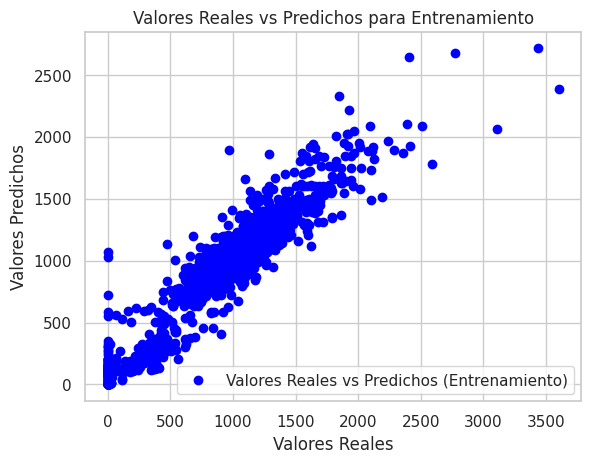

In [ ]:
# Graficar valores reales vs predichos para entrenamiento
plt.scatter(y_train, y_pred_train, color='blue', label='Valores Reales vs Predichos (Entrenamiento)')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs Predichos para Entrenamiento')
plt.legend()
plt.show()



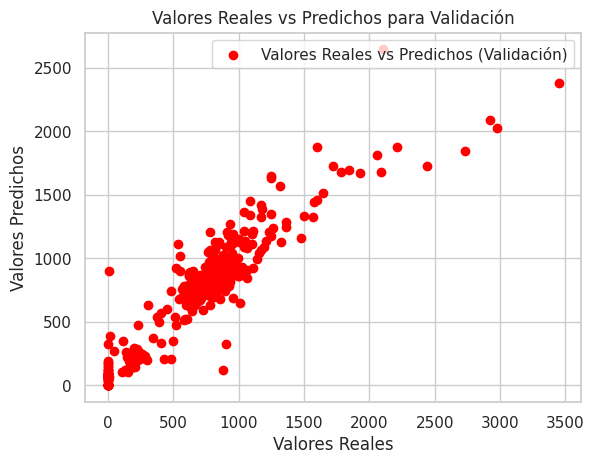

In [ ]:
# Graficar valores reales vs predichos para validación
plt.scatter(y_val, y_pred_val, color='red', label='Valores Reales vs Predichos (Validación)')
plt.xlabel('Valores Reales')
plt.ylabel('Valores Predichos')
plt.title('Valores Reales vs Predichos para Validación')
plt.legend()
plt.show()

In [ ]:
data_train['Fecha'] = pd.to_datetime(data_train['anio'].astype(str) + '-' + data_train['mes'].astype(str) + '-' + data_train['diaMes'].astype(str), format='%Y-%m-%d')
data_val['Fecha'] = pd.to_datetime(data_val['anio'].astype(str) + '-' + data_val['mes'].astype(str) + '-' + data_val['diaMes'].astype(str), format='%Y-%m-%d')

# Crear un DataFrame con las fechas, valores reales y valores predichos para entrenamiento
df_train_plot = pd.DataFrame({'Fecha': data_train['Fecha'], 'Valores Reales': y_train, 'Valores Predichos': y_pred_train})

# Crear el gráfico de serie de tiempo con Plotly Express para entrenamiento
fig_train = px.line(df_train_plot, x='Fecha', y=['Valores Reales', 'Valores Predichos'],
                    title='Serie de Tiempo - Valores Reales vs Predichos (Entrenamiento)',
                    labels={'value': 'Unidades', 'Fecha': 'Fecha'})
fig_train.update_traces(mode='markers+lines')

# Mostrar el gráfico
fig_train.show()

In [ ]:
import plotly.express as px

# Crear un DataFrame con las fechas, valores reales y valores predichos
df_plot = pd.DataFrame({'Fecha': data_val['Fecha'], 'Valores Reales': y_val, 'Valores Predichos': y_pred_val})

# Crear el gráfico de serie de tiempo con Plotly Express
fig = px.line(df_plot, x='Fecha', y=['Valores Reales', 'Valores Predichos'],
              title='Serie de Tiempo - Valores Reales vs Predichos (Validación)',
              labels={'value': 'Unidades', 'Fecha': 'Fecha'})
fig.update_traces(mode='markers+lines')

# Mostrar el gráfico
fig.show()

### ***2: Luis***

### ***3: Anderson***